Train DHG

In [17]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np

# Load and preprocess data
def load_and_preprocess_data(file_path, sequence_length=12):
    # Load the CSV file with 'time' as index
    df = pd.read_csv(file_path, index_col='time')

    # Convert index (time) to datetime format
    df.index = pd.to_datetime(df.index)

    # Split data based on date
    split_date = pd.to_datetime('2025-01-01')
    train_df = df[df.index < split_date]
    test_df = df[df.index >= split_date]

    # Prepare features and target for train set
    features_train = train_df[['DHG', 'VNINDEX_lag2', 'PHARMA_lag1']].values
    target_train = train_df['target'].values

    # Prepare features and target for test set
    features_test = test_df[['DHG', 'VNINDEX_lag2', 'PHARMA_lag1']].values
    target_test = test_df['target'].values

    # Get list of dates from test set index
    test_dates = test_df.index

    # Check train and test set sizes
    print(f"Train size: {len(train_df)}")
    print(f"Test size: {len(test_df)}")

    # Check class distribution
    print("Class distribution in train set:")
    print(pd.Series(target_train).value_counts())
    print("Class distribution in test set:")
    print(pd.Series(target_test).value_counts())

    # Normalize features
    scaler = StandardScaler()
    features_train = scaler.fit_transform(features_train)
    features_test = scaler.transform(features_test)  # Use transform on test set

    # Create sequences for train set
    X_train, y_train = [], []
    for i in range(len(features_train) - sequence_length):
        X_train.append(features_train[i:i + sequence_length])
        y_train.append(target_train[i + sequence_length])
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Create sequences for test set
    X_test, y_test = [], []
    test_dates_seq = []  # Store dates corresponding to each sequence
    for i in range(len(features_test) - sequence_length):
        X_test.append(features_test[i:i + sequence_length])
        y_test.append(target_test[i + sequence_length])
        # Take the start date of the sequence (date at position i)
        test_dates_seq.append(test_dates[i])
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    test_dates_seq = pd.to_datetime(test_dates_seq)  # Ensure datetime format

    # Convert to torch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # Dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32)

    return train_loader, test_loader, X_test, y_test, test_dates_seq, target_train

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # No sigmoid here as we'll use BCEWithLogitsLoss

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Function to save the model
def save_model(model, path='LSTM_DHG_Classification.pth'):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Training loop
def train(model, loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch_x, batch_y in loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = (torch.sigmoid(outputs).squeeze() > 0.5).float()
            batch_y_binary = batch_y.round()

            for p, t in zip(predicted, batch_y_binary):
                if p == t:
                    correct_predictions += 1
            total_samples += batch_y.size(0)

        accuracy = correct_predictions / total_samples
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy * 100:.2f}%")

# Main function for training and saving
def main_train(file_path, model_path='models/LSTM/LSTM_DHG_Classification.pth'):
    train_loader, _, X_test, _, _, target_train = load_and_preprocess_data(file_path)

    input_dim = X_test.shape[2]
    hidden_dim = 128  # Increased hidden_dim for more complexity
    output_dim = 1

    # Create new model and train
    model = LSTMModel(input_dim, hidden_dim, output_dim)

    # Use BCEWithLogitsLoss with pos_weight to handle imbalanced data
    pos_weight = torch.tensor([len(target_train[target_train == 0]) / len(target_train[target_train == 1])])
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train(model, train_loader, criterion, optimizer, epochs=100)  # Increased number of epochs

    # Save the trained model
    save_model(model, path=model_path)

# Run the script
if __name__ == "__main__":
    file_path = "data/DHG_PHARM_VNINDEX.csv"
    main_train(file_path, model_path='models/LSTM/LSTM_DHG_Classification.pth')

Train size: 2636
Test size: 56
Class distribution in train set:
0    1578
1    1058
Name: count, dtype: int64
Class distribution in test set:
0    33
1    23
Name: count, dtype: int64
Epoch 1/100, Loss: 68.1042, Accuracy: 51.33%
Epoch 2/100, Loss: 68.1823, Accuracy: 45.27%
Epoch 3/100, Loss: 68.0498, Accuracy: 49.16%
Epoch 4/100, Loss: 68.0336, Accuracy: 49.28%
Epoch 5/100, Loss: 68.0118, Accuracy: 49.47%
Epoch 6/100, Loss: 67.9858, Accuracy: 49.35%
Epoch 7/100, Loss: 67.9671, Accuracy: 48.78%
Epoch 8/100, Loss: 67.9514, Accuracy: 48.36%
Epoch 9/100, Loss: 67.9371, Accuracy: 47.94%
Epoch 10/100, Loss: 67.9244, Accuracy: 47.98%
Epoch 11/100, Loss: 67.9081, Accuracy: 48.40%
Epoch 12/100, Loss: 67.8995, Accuracy: 48.67%
Epoch 13/100, Loss: 67.8771, Accuracy: 49.77%
Epoch 14/100, Loss: 67.8647, Accuracy: 49.62%
Epoch 15/100, Loss: 67.8110, Accuracy: 49.77%
Epoch 16/100, Loss: 67.7980, Accuracy: 49.43%
Epoch 17/100, Loss: 67.7996, Accuracy: 49.35%
Epoch 18/100, Loss: 67.7161, Accuracy: 49.9

Load DHG

Test size: 56
Class distribution in test set:
0    33
1    23
Name: count, dtype: int64
Model loaded from models/LSTM/LSTM_DHG_Classification.pth

Threshold: 0.5
Test Accuracy: 0.5909
Precision: 0.4762
Recall: 0.5882
F1-Score: 0.5263

Sample of Actual vs Predicted Values:
         Date  Actual  Predicted
0  2025-01-20     0.0      False
1  2025-01-21     1.0      False
2  2025-01-22     0.0       True
3  2025-01-23     1.0       True
4  2025-01-24     0.0       True
5  2025-02-03     1.0       True
6  2025-02-04     1.0       True
7  2025-02-05     1.0       True
8  2025-02-06     0.0       True
9  2025-02-07     0.0      False
10 2025-02-10     1.0      False
11 2025-02-11     0.0       True
12 2025-02-13     1.0       True
13 2025-02-14     0.0       True
14 2025-02-17     1.0       True
15 2025-02-18     0.0       True
16 2025-02-19     1.0       True
17 2025-02-20     0.0       True
18 2025-02-21     1.0       True
19 2025-02-24     0.0      False
20 2025-02-25     1.0      False
2

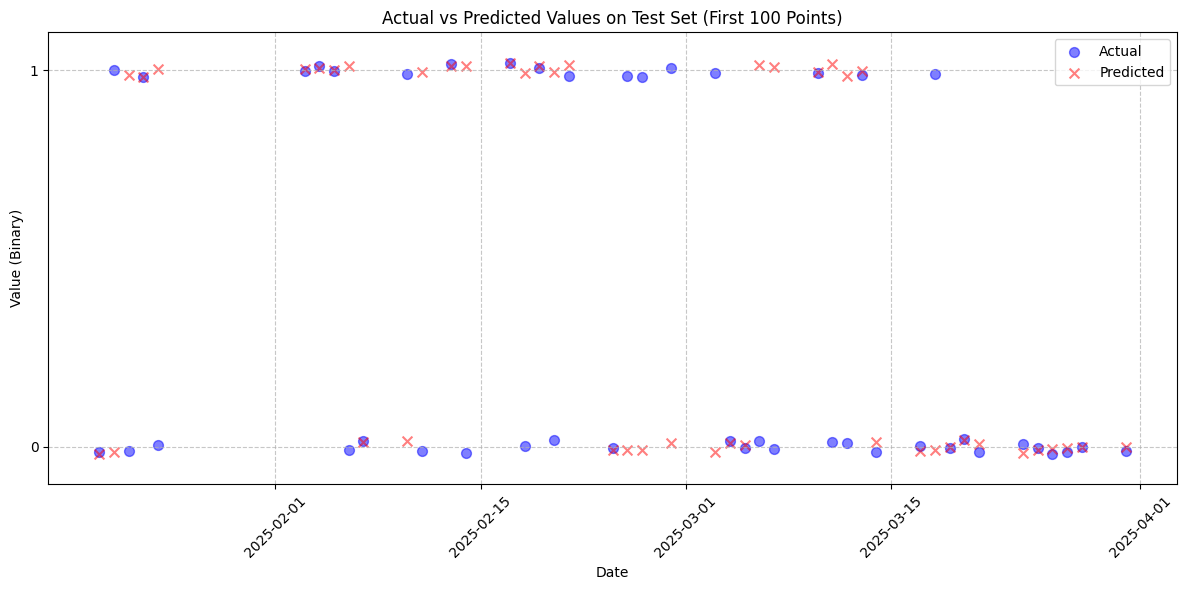

In [35]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import os

# Load and preprocess data (simplified for test set only)
def load_and_preprocess_data(file_path, sequence_length=12):
    # Load the CSV file with 'time' as index
    df = pd.read_csv(file_path, index_col='time')

    # Convert index (time) to datetime format
    df.index = pd.to_datetime(df.index)

    # Split data based on date
    split_date = pd.to_datetime('2025-01-01')
    test_df = df[df.index >= split_date]

    # Prepare features and target for test set
    features_test = test_df[['DHG', 'VNINDEX_lag2', 'PHARMA_lag1']].values
    target_test = test_df['target'].values

    # Get list of dates from test set index
    test_dates = test_df.index

    # Check test set size
    print(f"Test size: {len(test_df)}")

    # Check class distribution in test set
    print("Class distribution in test set:")
    print(pd.Series(target_test).value_counts())

    # Normalize features
    scaler = StandardScaler()
    features_test = scaler.fit_transform(features_test)  # Simplified: fit_transform on test set

    # Create sequences for test set
    X_test, y_test = [], []
    test_dates_seq = []
    for i in range(len(features_test) - sequence_length):
        X_test.append(features_test[i:i + sequence_length])
        y_test.append(target_test[i + sequence_length])
        # Take the date corresponding to the target
        test_dates_seq.append(test_dates[i + sequence_length])
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    test_dates_seq = pd.to_datetime(test_dates_seq)

    # Convert to torch tensors
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # Dataloader for test set
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=32)

    return test_loader, X_test, y_test, test_dates_seq

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Function to load the model
def load_model(input_dim, hidden_dim, output_dim, path='models/LSTM/LSTM_DHG_Classification.pth'):
    model = LSTMModel(input_dim, hidden_dim, output_dim)
    if os.path.exists(path):
        model.load_state_dict(torch.load(path))
        print(f"Model loaded from {path}")
    else:
        raise FileNotFoundError(f"No saved model found at {path}")
    return model

# Simplified evaluation: only compute metrics and predictions
def evaluate(model, loader):
    model.eval()
    predictions, labels = [], []
    with torch.no_grad():
        for batch_x, batch_y in loader:
            outputs = model(batch_x)
            predictions.extend(outputs.squeeze().numpy())
            labels.extend(batch_y.squeeze().numpy())

    # Convert to probabilities
    predictions_prob = torch.sigmoid(torch.tensor(predictions)).numpy()
    labels = np.array(labels)

    # Use a single threshold
    threshold = 0.5
    predictions = predictions_prob > threshold
    accuracy = (predictions == labels).mean()
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

    print(f"\nThreshold: {threshold}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return predictions, labels, threshold

# Display table of results
def display_table(predictions, labels, dates, max_rows=100):
    df = pd.DataFrame({
        'Date': dates[:max_rows],
        'Actual': labels[:max_rows],
        'Predicted': predictions[:max_rows]
    })
    print("\nSample of Actual vs Predicted Values:")
    print(df)

# Plot predictions vs actual labels
def plot_predictions(predictions, labels, dates, max_points=100):
    plt.figure(figsize=(12, 6))

    # Take up to max_points for plotting
    dates_subset = dates[:max_points]
    labels_subset = labels[:max_points]
    predictions_subset = predictions[:max_points]

    # Add small jitter to avoid complete overlap
    jitter = 0.02
    labels_jittered = labels_subset + np.random.uniform(-jitter, jitter, size=len(labels_subset))
    predictions_jittered = predictions_subset + np.random.uniform(-jitter, jitter, size=len(predictions_subset))

    # Plot actual values
    plt.scatter(dates_subset, labels_jittered, label='Actual', color='blue', marker='o', alpha=0.5, s=50)
    # Plot predicted values
    plt.scatter(dates_subset, predictions_jittered, label='Predicted', color='red', marker='x', alpha=0.5, s=50)

    plt.title('Actual vs Predicted Values on Test Set (First 100 Points)')
    plt.xlabel('Date')
    plt.ylabel('Value (Binary)')
    plt.ylim(-0.1, 1.1)
    plt.yticks([0, 1], ['0', '1'])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)  # Rotate date labels for readability
    plt.tight_layout()  # Ensure labels are not cut off
    plt.show()

# Main function for loading and evaluating
def main_evaluate(file_path, model_path='models/LSTM/LSTM_DHG_Classification.pth'):
    test_loader, X_test, y_test, test_dates = load_and_preprocess_data(file_path)

    input_dim = X_test.shape[2]
    hidden_dim = 128  # Must match the hidden_dim used during training
    output_dim = 1

    # Load existing model
    model = load_model(input_dim, hidden_dim, output_dim, path=model_path)

    # Evaluate and get predictions
    predictions, labels, threshold = evaluate(model, test_loader)

    # Display results table
    display_table(predictions, labels, test_dates, max_rows=100)
    
    plot_predictions(predictions, labels, test_dates, max_points=100)


# Run the script
if __name__ == "__main__":
    file_path = "data/DHG_PHARM_VNINDEX.csv"
    main_evaluate(file_path, model_path='models/LSTM/LSTM_DHG_Classification.pth')
    
# Threshold: 0.5
# Test Accuracy: 0.5909
# Precision: 0.4762
# Recall: 0.5882
# F1-Score: 0.5263

TRA Train

In [47]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np

# Load and preprocess data
def load_and_preprocess_data(file_path, sequence_length=12):
    # Load the CSV file with 'time' as index
    df = pd.read_csv(file_path, index_col='time')

    # Convert index (time) to datetime format
    df.index = pd.to_datetime(df.index)

    # Split data based on date
    split_date = pd.to_datetime('2025-01-01')
    train_df = df[df.index < split_date]
    test_df = df[df.index >= split_date]

    # Prepare features and target for train set
    features_train = train_df[['TRA', 'VNINDEX_lag2', 'PHARMA_lag1']].values
    target_train = train_df['target'].values

    # Prepare features and target for test set
    features_test = test_df[['TRA', 'VNINDEX_lag2', 'PHARMA_lag1']].values
    target_test = test_df['target'].values

    # Get list of dates from test set index
    test_dates = test_df.index

    # Check train and test set sizes
    print(f"Train size: {len(train_df)}")
    print(f"Test size: {len(test_df)}")

    # Check class distribution
    print("Class distribution in train set:")
    print(pd.Series(target_train).value_counts())
    print("Class distribution in test set:")
    print(pd.Series(target_test).value_counts())

    # Normalize features
    scaler = StandardScaler()
    features_train = scaler.fit_transform(features_train)
    features_test = scaler.transform(features_test)  # Use transform on test set

    # Create sequences for train set
    X_train, y_train = [], []
    for i in range(len(features_train) - sequence_length):
        X_train.append(features_train[i:i + sequence_length])
        y_train.append(target_train[i + sequence_length])
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Create sequences for test set
    X_test, y_test = [], []
    test_dates_seq = []  # Store dates corresponding to each sequence
    for i in range(len(features_test) - sequence_length):
        X_test.append(features_test[i:i + sequence_length])
        y_test.append(target_test[i + sequence_length])
        # Take the start date of the sequence (date at position i)
        test_dates_seq.append(test_dates[i])
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    test_dates_seq = pd.to_datetime(test_dates_seq)  # Ensure datetime format

    # Convert to torch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # Dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32)

    return train_loader, test_loader, X_test, y_test, test_dates_seq, target_train

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # No sigmoid here as we'll use BCEWithLogitsLoss

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Function to save the model
def save_model(model, path='models/LSTM/LSTM_TRA_Classification.pth'):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Training loop
def train(model, loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch_x, batch_y in loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = (torch.sigmoid(outputs).squeeze() > 0.5).float()
            batch_y_binary = batch_y.round()

            for p, t in zip(predicted, batch_y_binary):
                if p == t:
                    correct_predictions += 1
            total_samples += batch_y.size(0)

        accuracy = correct_predictions / total_samples
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy * 100:.2f}%")

# Main function for training and saving
def main_train(file_path, model_path='models/LSTM/LSTM_TRA_Classification.pth'):
    train_loader, _, X_test, _, _, target_train = load_and_preprocess_data(file_path)

    input_dim = X_test.shape[2]
    hidden_dim = 128  # Increased hidden_dim for more complexity
    output_dim = 1

    # Create new model and train
    model = LSTMModel(input_dim, hidden_dim, output_dim)

    # Use BCEWithLogitsLoss with pos_weight to handle imbalanced data
    pos_weight = torch.tensor([len(target_train[target_train == 0]) / len(target_train[target_train == 1])])
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train(model, train_loader, criterion, optimizer, epochs=100)  # Increased number of epochs

    # Save the trained model
    save_model(model, path=model_path)

# Run the script
if __name__ == "__main__":
    file_path = "data/TRA_PHARM_VNINDEX.csv"
    main_train(file_path, model_path='models/LSTM/LSTM_TRA_Classification.pth')

Train size: 2634
Test size: 56
Class distribution in train set:
0    1672
1     962
Name: count, dtype: int64
Class distribution in test set:
0    37
1    19
Name: count, dtype: int64
Epoch 1/100, Loss: 72.3620, Accuracy: 55.53%
Epoch 2/100, Loss: 72.5300, Accuracy: 49.31%
Epoch 3/100, Loss: 72.2896, Accuracy: 54.20%
Epoch 4/100, Loss: 72.2259, Accuracy: 53.17%
Epoch 5/100, Loss: 72.2008, Accuracy: 52.97%
Epoch 6/100, Loss: 72.1743, Accuracy: 52.86%
Epoch 7/100, Loss: 72.1396, Accuracy: 50.50%
Epoch 8/100, Loss: 72.0949, Accuracy: 49.73%
Epoch 9/100, Loss: 72.0567, Accuracy: 50.61%
Epoch 10/100, Loss: 72.0265, Accuracy: 51.37%
Epoch 11/100, Loss: 71.9972, Accuracy: 52.82%
Epoch 12/100, Loss: 71.9553, Accuracy: 52.40%
Epoch 13/100, Loss: 71.9123, Accuracy: 52.25%
Epoch 14/100, Loss: 71.8926, Accuracy: 53.51%
Epoch 15/100, Loss: 71.8740, Accuracy: 53.05%
Epoch 16/100, Loss: 71.8734, Accuracy: 52.97%
Epoch 17/100, Loss: 71.7746, Accuracy: 54.81%
Epoch 18/100, Loss: 71.7729, Accuracy: 55.3

Load TRA

Test size: 56
Class distribution in test set:
0    37
1    19
Name: count, dtype: int64
Model loaded from models/LSTM/LSTM_TRA_Classification.pth

Threshold: 0.5
Test Accuracy: 0.4773
Precision: 0.3714
Recall: 0.9286
F1-Score: 0.5306

Sample of Actual vs Predicted Values:
         Date  Actual  Predicted
0  2025-01-20     0.0       True
1  2025-01-21     1.0      False
2  2025-01-22     0.0      False
3  2025-01-23     0.0      False
4  2025-01-24     0.0       True
5  2025-02-03     0.0       True
6  2025-02-04     1.0       True
7  2025-02-05     1.0       True
8  2025-02-06     1.0       True
9  2025-02-07     0.0       True
10 2025-02-10     1.0       True
11 2025-02-11     1.0       True
12 2025-02-13     0.0       True
13 2025-02-14     0.0       True
14 2025-02-17     0.0       True
15 2025-02-18     0.0       True
16 2025-02-19     0.0       True
17 2025-02-20     1.0       True
18 2025-02-21     1.0       True
19 2025-02-24     0.0       True
20 2025-02-25     1.0       True
2

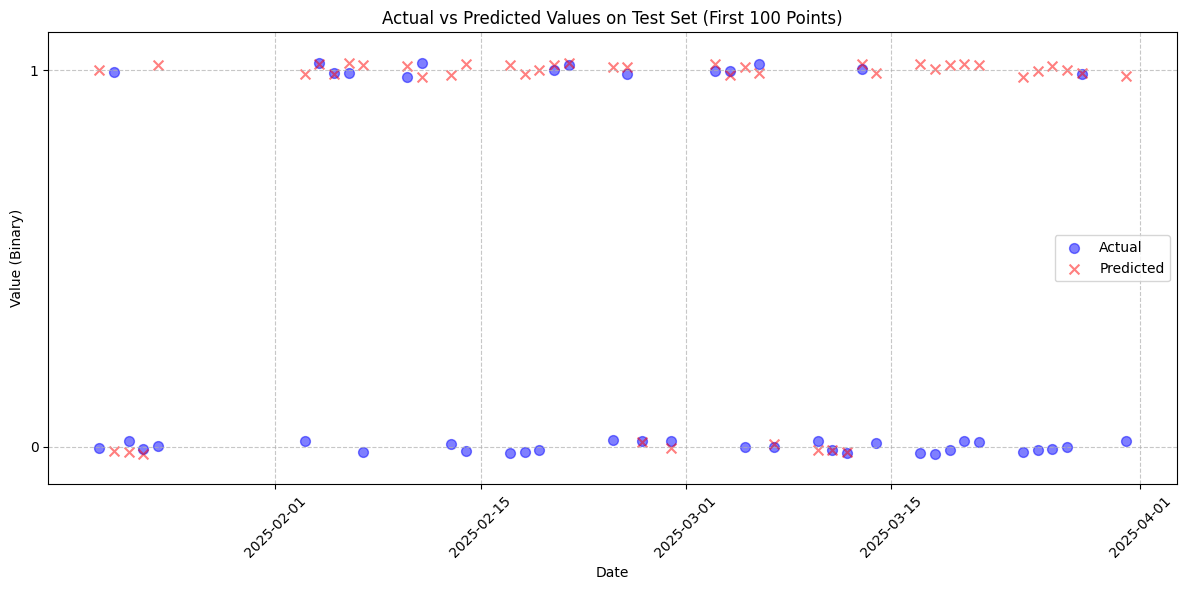

In [50]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import os
import matplotlib.pyplot as plt

# Load and preprocess data (simplified for test set only)
def load_and_preprocess_data(file_path, sequence_length=12):
    # Load the CSV file with 'time' as index
    df = pd.read_csv(file_path, index_col='time')

    # Convert index (time) to datetime format
    df.index = pd.to_datetime(df.index)

    # Split data based on date
    split_date = pd.to_datetime('2025-01-01')
    test_df = df[df.index >= split_date]

    # Prepare features and target for test set
    features_test = test_df[['TRA', 'VNINDEX_lag2', 'PHARMA_lag1']].values
    target_test = test_df['target'].values

    # Get list of dates from test set index
    test_dates = test_df.index

    # Check test set size
    print(f"Test size: {len(test_df)}")

    # Check class distribution in test set
    print("Class distribution in test set:")
    print(pd.Series(target_test).value_counts())

    # Normalize features
    scaler = StandardScaler()
    features_test = scaler.fit_transform(features_test)  # Simplified: fit_transform on test set

    # Create sequences for test set
    X_test, y_test = [], []
    test_dates_seq = []
    for i in range(len(features_test) - sequence_length):
        X_test.append(features_test[i:i + sequence_length])
        y_test.append(target_test[i + sequence_length])
        # Take the date corresponding to the target
        test_dates_seq.append(test_dates[i + sequence_length])
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    test_dates_seq = pd.to_datetime(test_dates_seq)

    # Convert to torch tensors
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # Dataloader for test set
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=32)

    return test_loader, X_test, y_test, test_dates_seq

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Function to load the model
def load_model(input_dim, hidden_dim, output_dim, path='models/LSTM/LSTM_TRA_Classification.pth'):
    model = LSTMModel(input_dim, hidden_dim, output_dim)
    if os.path.exists(path):
        model.load_state_dict(torch.load(path))
        print(f"Model loaded from {path}")
    else:
        raise FileNotFoundError(f"No saved model found at {path}")
    return model

# Simplified evaluation: only compute metrics and predictions
def evaluate(model, loader):
    model.eval()
    predictions, labels = [], []
    with torch.no_grad():
        for batch_x, batch_y in loader:
            outputs = model(batch_x)
            predictions.extend(outputs.squeeze().numpy())
            labels.extend(batch_y.squeeze().numpy())

    # Convert to probabilities
    predictions_prob = torch.sigmoid(torch.tensor(predictions)).numpy()
    labels = np.array(labels)

    # Use a single threshold
    
    threshold = 0.5
    predictions = predictions_prob > threshold
    accuracy = (predictions == labels).mean()
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

    print(f"\nThreshold: {threshold}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return predictions, labels, threshold

# Display table of results
def display_table(predictions, labels, dates, max_rows=100):
    df = pd.DataFrame({
        'Date': dates[:max_rows],
        'Actual': labels[:max_rows],
        'Predicted': predictions[:max_rows]
    })
    print("\nSample of Actual vs Predicted Values:")
    print(df)

# Plot predictions vs actual labels
def plot_predictions(predictions, labels, dates, max_points=100):
    plt.figure(figsize=(12, 6))

    # Take up to max_points for plotting
    dates_subset = dates[:max_points]
    labels_subset = labels[:max_points]
    predictions_subset = predictions[:max_points]

    # Add small jitter to avoid complete overlap
    jitter = 0.02
    labels_jittered = labels_subset + np.random.uniform(-jitter, jitter, size=len(labels_subset))
    predictions_jittered = predictions_subset + np.random.uniform(-jitter, jitter, size=len(predictions_subset))

    # Plot actual values
    plt.scatter(dates_subset, labels_jittered, label='Actual', color='blue', marker='o', alpha=0.5, s=50)
    # Plot predicted values
    plt.scatter(dates_subset, predictions_jittered, label='Predicted', color='red', marker='x', alpha=0.5, s=50)

    plt.title('Actual vs Predicted Values on Test Set (First 100 Points)')
    plt.xlabel('Date')
    plt.ylabel('Value (Binary)')
    plt.ylim(-0.1, 1.1)
    plt.yticks([0, 1], ['0', '1'])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)  # Rotate date labels for readability
    plt.tight_layout()  # Ensure labels are not cut off
    plt.show()


# Main function for loading and evaluating
def main_evaluate(file_path, model_path='models/LSTM/LSTM_TRA_Classification.pth'):
    test_loader, X_test, y_test, test_dates = load_and_preprocess_data(file_path)

    input_dim = X_test.shape[2]
    hidden_dim = 128  # Must match the hidden_dim used during training
    output_dim = 1

    # Load existing model
    model = load_model(input_dim, hidden_dim, output_dim, path=model_path)

    # Evaluate and get predictions
    predictions, labels, threshold = evaluate(model, test_loader)

    # Display results table
    display_table(predictions, labels, test_dates, max_rows=100)
    
    plot_predictions(predictions, labels, test_dates, max_points=100)

# Run the script
if __name__ == "__main__":
    file_path = "data/TRA_PHARM_VNINDEX.csv"
    main_evaluate(file_path, model_path='models/LSTM/LSTM_TRA_Classification.pth')

# Threshold: 0.55
# Test Accuracy: 0.5227
# Precision: 0.3333
# Recall: 0.5000
# F1-Score: 0.4000

# Threshold: 0.5
# Test Accuracy: 0.4773
# Precision: 0.3714
# Recall: 0.9286
# F1-Score: 0.5306


Train IMP

In [37]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np

# Load and preprocess data
def load_and_preprocess_data(file_path, sequence_length=12):
    # Load the CSV file with 'time' as index
    df = pd.read_csv(file_path, index_col='time')

    # Convert index (time) to datetime format
    df.index = pd.to_datetime(df.index)

    # Split data based on date
    split_date = pd.to_datetime('2025-01-01')
    train_df = df[df.index < split_date]
    test_df = df[df.index >= split_date]

    # Prepare features and target for train set
    features_train = train_df[['IMP', 'VNINDEX_lag2', 'PHARMA_lag1']].values
    target_train = train_df['target'].values

    # Prepare features and target for test set
    features_test = test_df[['IMP', 'VNINDEX_lag2', 'PHARMA_lag1']].values
    target_test = test_df['target'].values

    # Get list of dates from test set index
    test_dates = test_df.index

    # Check train and test set sizes
    print(f"Train size: {len(train_df)}")
    print(f"Test size: {len(test_df)}")

    # Check class distribution
    print("Class distribution in train set:")
    print(pd.Series(target_train).value_counts())
    print("Class distribution in test set:")
    print(pd.Series(target_test).value_counts())

    # Normalize features
    scaler = StandardScaler()
    features_train = scaler.fit_transform(features_train)
    features_test = scaler.transform(features_test)  # Use transform on test set

    # Create sequences for train set
    X_train, y_train = [], []
    for i in range(len(features_train) - sequence_length):
        X_train.append(features_train[i:i + sequence_length])
        y_train.append(target_train[i + sequence_length])
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Create sequences for test set
    X_test, y_test = [], []
    test_dates_seq = []  # Store dates corresponding to each sequence
    for i in range(len(features_test) - sequence_length):
        X_test.append(features_test[i:i + sequence_length])
        y_test.append(target_test[i + sequence_length])
        # Take the start date of the sequence (date at position i)
        test_dates_seq.append(test_dates[i])
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    test_dates_seq = pd.to_datetime(test_dates_seq)  # Ensure datetime format

    # Convert to torch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # Dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32)

    return train_loader, test_loader, X_test, y_test, test_dates_seq, target_train

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # No sigmoid here as we'll use BCEWithLogitsLoss

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Function to save the model
def save_model(model, path='models/LSTM/LSTM_IMP_Classification.pth'):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Training loop
def train(model, loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch_x, batch_y in loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = (torch.sigmoid(outputs).squeeze() > 0.5).float()
            batch_y_binary = batch_y.round()

            for p, t in zip(predicted, batch_y_binary):
                if p == t:
                    correct_predictions += 1
            total_samples += batch_y.size(0)

        accuracy = correct_predictions / total_samples
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy * 100:.2f}%")

# Main function for training and saving
def main_train(file_path, model_path='models/LSTM/LSTM_IMP_Classification.pth'):
    train_loader, _, X_test, _, _, target_train = load_and_preprocess_data(file_path)

    input_dim = X_test.shape[2]
    hidden_dim = 128  # Increased hidden_dim for more complexity
    output_dim = 1

    # Create new model and train
    model = LSTMModel(input_dim, hidden_dim, output_dim)

    # Use BCEWithLogitsLoss with pos_weight to handle imbalanced data
    pos_weight = torch.tensor([len(target_train[target_train == 0]) / len(target_train[target_train == 1])])
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train(model, train_loader, criterion, optimizer, epochs=100)  # Increased number of epochs

    # Save the trained model
    save_model(model, path=model_path)

# Run the script
if __name__ == "__main__":
    file_path = "data/IMP_PHARM_VNINDEX.csv"
    main_train(file_path, model_path='models/LSTM/LSTM_IMP_Classification.pth')

Train size: 2636
Test size: 56
Class distribution in train set:
0    1577
1    1059
Name: count, dtype: int64
Class distribution in test set:
0    31
1    25
Name: count, dtype: int64
Epoch 1/100, Loss: 68.1795, Accuracy: 48.67%
Epoch 2/100, Loss: 68.0852, Accuracy: 46.61%
Epoch 3/100, Loss: 68.0717, Accuracy: 47.83%
Epoch 4/100, Loss: 68.0623, Accuracy: 47.79%
Epoch 5/100, Loss: 68.0549, Accuracy: 47.90%
Epoch 6/100, Loss: 68.0485, Accuracy: 47.98%
Epoch 7/100, Loss: 68.0425, Accuracy: 48.02%
Epoch 8/100, Loss: 68.0356, Accuracy: 47.98%
Epoch 9/100, Loss: 68.0328, Accuracy: 47.90%
Epoch 10/100, Loss: 68.0472, Accuracy: 47.33%
Epoch 11/100, Loss: 68.0238, Accuracy: 48.78%
Epoch 12/100, Loss: 68.0149, Accuracy: 48.29%
Epoch 13/100, Loss: 68.0068, Accuracy: 48.82%
Epoch 14/100, Loss: 68.0055, Accuracy: 48.63%
Epoch 15/100, Loss: 68.0279, Accuracy: 49.31%
Epoch 16/100, Loss: 68.0613, Accuracy: 49.81%
Epoch 17/100, Loss: 68.0494, Accuracy: 47.45%
Epoch 18/100, Loss: 68.0282, Accuracy: 48.8

Test size: 56
Class distribution in test set:
0    31
1    25
Name: count, dtype: int64
Model loaded from models/LSTM/LSTM_IMP_Classification.pth

Threshold: 0.55
Test Accuracy: 0.6136
Precision: 1.0000
Recall: 0.1053
F1-Score: 0.1905

Sample of Actual vs Predicted Values:
         Date  Actual  Predicted
0  2025-01-20     0.0      False
1  2025-01-21     1.0      False
2  2025-01-22     0.0      False
3  2025-01-23     0.0      False
4  2025-01-24     1.0      False
5  2025-02-03     1.0      False
6  2025-02-04     0.0      False
7  2025-02-05     1.0      False
8  2025-02-06     1.0      False
9  2025-02-07     0.0      False
10 2025-02-10     1.0      False
11 2025-02-11     0.0      False
12 2025-02-13     1.0      False
13 2025-02-14     1.0      False
14 2025-02-17     1.0      False
15 2025-02-18     0.0      False
16 2025-02-19     1.0      False
17 2025-02-20     0.0      False
18 2025-02-21     0.0      False
19 2025-02-24     0.0      False
20 2025-02-25     1.0      False


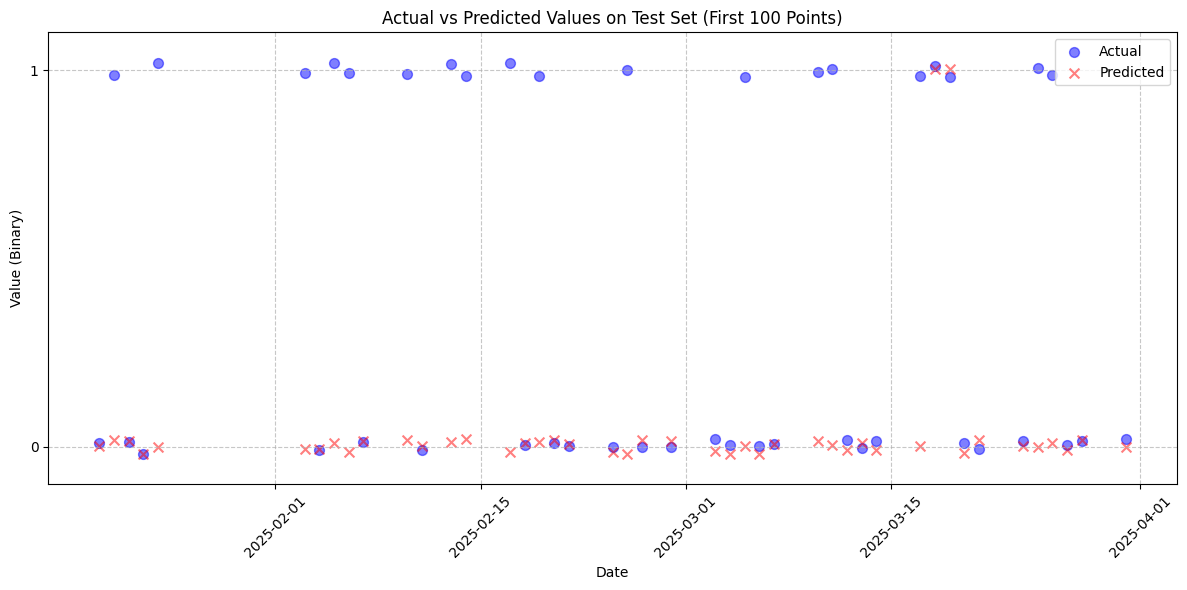

In [40]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import os
import matplotlib.pyplot as plt

# Load and preprocess data (simplified for test set only)
def load_and_preprocess_data(file_path, sequence_length=12):
    # Load the CSV file with 'time' as index
    df = pd.read_csv(file_path, index_col='time')

    # Convert index (time) to datetime format
    df.index = pd.to_datetime(df.index)

    # Split data based on date
    split_date = pd.to_datetime('2025-01-01')
    test_df = df[df.index >= split_date]

    # Prepare features and target for test set
    features_test = test_df[['IMP', 'VNINDEX_lag2', 'PHARMA_lag1']].values
    target_test = test_df['target'].values

    # Get list of dates from test set index
    test_dates = test_df.index

    # Check test set size
    print(f"Test size: {len(test_df)}")

    # Check class distribution in test set
    print("Class distribution in test set:")
    print(pd.Series(target_test).value_counts())

    # Normalize features
    scaler = StandardScaler()
    features_test = scaler.fit_transform(features_test)  # Simplified: fit_transform on test set

    # Create sequences for test set
    X_test, y_test = [], []
    test_dates_seq = []
    for i in range(len(features_test) - sequence_length):
        X_test.append(features_test[i:i + sequence_length])
        y_test.append(target_test[i + sequence_length])
        # Take the date corresponding to the target
        test_dates_seq.append(test_dates[i + sequence_length])
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    test_dates_seq = pd.to_datetime(test_dates_seq)

    # Convert to torch tensors
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # Dataloader for test set
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=32)

    return test_loader, X_test, y_test, test_dates_seq

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Function to load the model
def load_model(input_dim, hidden_dim, output_dim, path='models/LSTM/LSTM_IMP_Classification.pth'):
    model = LSTMModel(input_dim, hidden_dim, output_dim)
    if os.path.exists(path):
        model.load_state_dict(torch.load(path))
        print(f"Model loaded from {path}")
    else:
        raise FileNotFoundError(f"No saved model found at {path}")
    return model

# Simplified evaluation: only compute metrics and predictions
def evaluate(model, loader):
    model.eval()
    predictions, labels = [], []
    with torch.no_grad():
        for batch_x, batch_y in loader:
            outputs = model(batch_x)
            predictions.extend(outputs.squeeze().numpy())
            labels.extend(batch_y.squeeze().numpy())

    # Convert to probabilities
    predictions_prob = torch.sigmoid(torch.tensor(predictions)).numpy()
    labels = np.array(labels)

    # Use a single threshold
    threshold = 0.45
    predictions = predictions_prob > threshold
    accuracy = (predictions == labels).mean()
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

    print(f"\nThreshold: {threshold}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return predictions, labels, threshold

# Display table of results
def display_table(predictions, labels, dates, max_rows=100):
    df = pd.DataFrame({
        'Date': dates[:max_rows],
        'Actual': labels[:max_rows],
        'Predicted': predictions[:max_rows]
    })
    print("\nSample of Actual vs Predicted Values:")
    print(df)

# Plot predictions vs actual labels
def plot_predictions(predictions, labels, dates, max_points=100):
    plt.figure(figsize=(12, 6))

    # Take up to max_points for plotting
    dates_subset = dates[:max_points]
    labels_subset = labels[:max_points]
    predictions_subset = predictions[:max_points]

    # Add small jitter to avoid complete overlap
    jitter = 0.02
    labels_jittered = labels_subset + np.random.uniform(-jitter, jitter, size=len(labels_subset))
    predictions_jittered = predictions_subset + np.random.uniform(-jitter, jitter, size=len(predictions_subset))

    # Plot actual values
    plt.scatter(dates_subset, labels_jittered, label='Actual', color='blue', marker='o', alpha=0.5, s=50)
    # Plot predicted values
    plt.scatter(dates_subset, predictions_jittered, label='Predicted', color='red', marker='x', alpha=0.5, s=50)

    plt.title('Actual vs Predicted Values on Test Set (First 100 Points)')
    plt.xlabel('Date')
    plt.ylabel('Value (Binary)')
    plt.ylim(-0.1, 1.1)
    plt.yticks([0, 1], ['0', '1'])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)  # Rotate date labels for readability
    plt.tight_layout()  # Ensure labels are not cut off
    plt.show()


# Main function for loading and evaluating
def main_evaluate(file_path, model_path='models/LSTM/LSTM_IMP_Classification.pth'):
    test_loader, X_test, y_test, test_dates = load_and_preprocess_data(file_path)

    input_dim = X_test.shape[2]
    hidden_dim = 128  # Must match the hidden_dim used during training
    output_dim = 1

    # Load existing model
    model = load_model(input_dim, hidden_dim, output_dim, path=model_path)

    # Evaluate and get predictions
    predictions, labels, threshold = evaluate(model, test_loader)

    # Display results table
    display_table(predictions, labels, test_dates, max_rows=100)
    
    plot_predictions(predictions, labels, test_dates, max_points=100)

# Run the script
if __name__ == "__main__":
    file_path = "data/IMP_PHARM_VNINDEX.csv"
    main_evaluate(file_path, model_path='models/LSTM/LSTM_IMP_Classification.pth')


# Threshold: 0.45
# Test Accuracy: 0.5909
# Precision: 0.5200
# Recall: 0.6842
# F1-Score: 0.5909